In [1]:
import sys
sys.path.append('..')
%env WORKDIR ~/Documents/weatherpy-work

env: WORKDIR=~/Documents/weatherpy-work


In [2]:
import pandas as pd
from shapely.geometry import Polygon

def load_chase_alley():
    bdys_df = pd.read_csv('chasealley.csv')
    latlon_mat = bdys_df[['lat', 'lon']].as_matrix()
    return bdys_df, Polygon(latlon_mat)

In [3]:
from wxdata import stormevents

df = stormevents.tornadoes('1996-01-01 00:00', '2016-12-31 12:31', tz='CST')

/Users/jitang/anaconda/envs/basemapenv/lib/python3.5/multiprocessing/pool.py:44: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/basemapenv/lib/python3.5/multiprocessing/pool.py:44: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/basemapenv/lib/python3.5/multiprocessing/pool.py:44: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/basemapenv/lib/python3.5/multiprocessing/pool.py:44: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))


In [8]:
df.columns

Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'magnitude', 'magnitude_type', 'flood_cause', 'category', 'tor_f_scale',
       'tor_length', 'tor_width', 'tor_other_wfo', 'tor_other_cz_state',
       'tor_other_cz_fips', 'tor_other_cz_name', 'begin_range',
       'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth',
       'end_location', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
       'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

In [137]:
# import importlib
# importlib.reload(stormevents)
# from wxdata.stormevents import filters
# importlib.reload(filters)

# from wxdata import utils
# importlib.reload(utils)

from wxdata.stormevents import tors
importlib.reload(tors)

# from wxdata.extras import clusters
# importlib.reload(clusters)

<module 'wxdata.stormevents.tornprocessing' from '../wxdata/stormevents/tornprocessing.py'>

In [26]:
_, chase_alley = load_chase_alley()
chaseable_tors = df.loc[df.month_name.isin(('April', 'May', 'June'))]
chaseable_tors = stormevents.filter_region(chaseable_tors, chase_alley)

In [42]:
hours = pd.to_numeric(df.begin_time.str[:2])
def in_aftn(df):
    return df[(hours >= 12) & (hours < 24)]

In [43]:
chaseable_tors = in_aftn(chaseable_tors)

/Users/jitang/anaconda/envs/basemapenv/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
chaseable_tors.head()

,begin_yearmonth,begin_day,begin_time,end_yearmonth,end_day,end_time,episode_id,event_id,state,state_fips,...,end_range,end_azimuth,end_location,begin_lat,begin_lon,end_lat,end_lon,episode_narrative,event_narrative,data_source
29,200904,9,1703,200904,9,1708,27926,168463,OKLAHOMA,40.0,...,4.0,ENE,VINITA,36.6312,-95.0933,36.6744,-95.0767,Widespread severe thunderstorms occurred acros...,"A tornado tore the roof off of a mobile home, ...",CSV
31,200905,25,1345,200905,25,1348,27972,164044,KANSAS,20.0,...,12.0,NW,HORACE,38.6117,-101.9203,38.6117,-101.9203,A slow-moving upper air low pressure system mo...,Law enforcement reported a tornado which laste...,CSV
32,200905,25,1220,200905,25,1221,27971,164058,COLORADO,8.0,...,3.0,N,STRATTON,39.3434,-102.6000,39.3434,-102.6000,A slow-moving upper air low pressure system mo...,Law enforcement reported a tornado north of St...,CSV
58,200905,12,1821,200905,12,1832,28842,169622,NEBRASKA,31.0,...,16.0,SSW,MULLEN,41.8415,-101.1933,41.8249,-101.1299,A supercell thunderstorm produced a tornado an...,Numerous trained storm spotters reported the t...,CSV
59,200905,23,1427,200905,23,1427,28835,169593,NEBRASKA,31.0,...,2.0,E,MAXWELL,41.0800,-100.4900,41.0800,-100.4900,Isolated storms produced a landspout tornado a...,Law enforcement reported a landspout tornado n...,CSV


In [49]:
len(chaseable_tors)

7023

In [126]:
from wxdata.plotting import simple_basemap
from wxdata.stormevents import tors

def chase_alley_map(hwys=False):
    layers = ['coastlines', 'countries', 'states', 'counties']
    if hwys:
        layers.append('highways')
    return simple_basemap(proj='merc', bbox=(-110.5, -87, 28, 50), draw=layers)

def plot_tors_on_chase_alley(tornadodata, color='brown', hwys=True, linewidth=2):
    m = chase_alley_map(hwys)
    tors.plot_tornadoes(tornadodata, m, linewidth=linewidth, color=color)
    return m

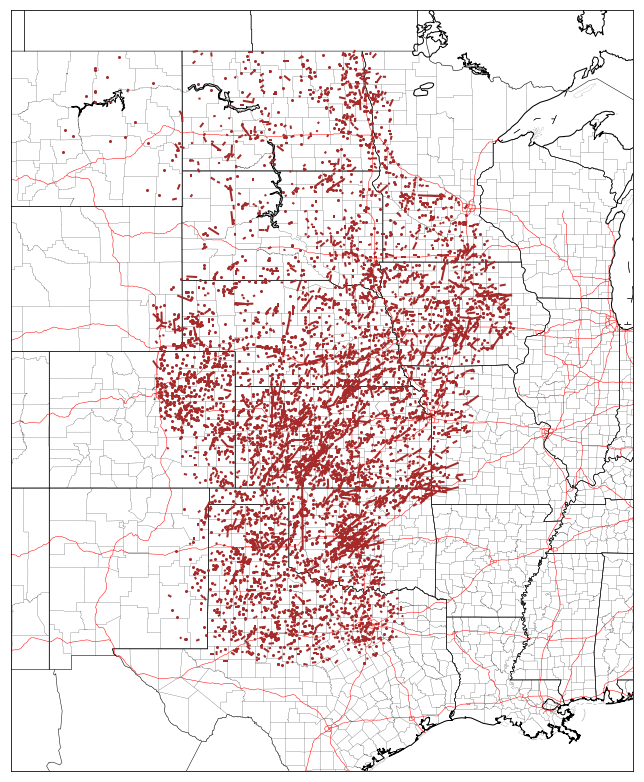

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 14))

plot_tors_on_chase_alley(chaseable_tors, color='brown')
# m.plot(chase_alley[:, 1], chase_alley[:, 0], latlon=True, linewidth=4, color='blue')

In [105]:
from wxdata.utils import datetime_buckets

def buckets_for_year(year):
    t1 = pd.Timestamp(year=year, month=4, day=1, hour=0, minute=0)
    t2 = pd.Timestamp(year=year, month=7, day=1, hour=0, minute=0)
    return datetime_buckets(t1, t2, dt=pd.Timedelta('1 day'))

In [146]:
from wxdata.extras import st_clusters
from wxdata.stormevents import filter_on_date

def clusters_for_year(year):
    ret = {}
    for bucket in buckets_for_year(year):
        start, end = bucket
        datetors = filter_on_date(chaseable_tors, start, tz='CST')
        
        dateclusts = st_clusters(datetors, eps_km=60, eps_min=60, min_samples=15)
        if dateclusts:
            ret[start] = dateclusts
            
    return ret

In [147]:
results = clusters_for_year(2016)

In [142]:
from wxdata.plotting import LegendBuilder

def plot_cluster_groups(clust_groups, buckets, hwys=True, linewidth=2, **kwargs):
    buckets = list(buckets)
    m = chase_alley_map(hwys)
    
    all_tors = []
    for clust_group in clust_groups:
        for clust in clust_group.clusters:
            clust_tors = clust.events
            all_tors.append(clust_tors)
            
    leg = LegendBuilder(loc=2)
    tors.plot_time_progression(pd.concat(all_tors), m, buckets, linewidth=linewidth, legend=leg, 
                               legend_handle_func=lambda bucket_start, bucket_end: bucket_start.strftime('%b %d'),
                              **kwargs)

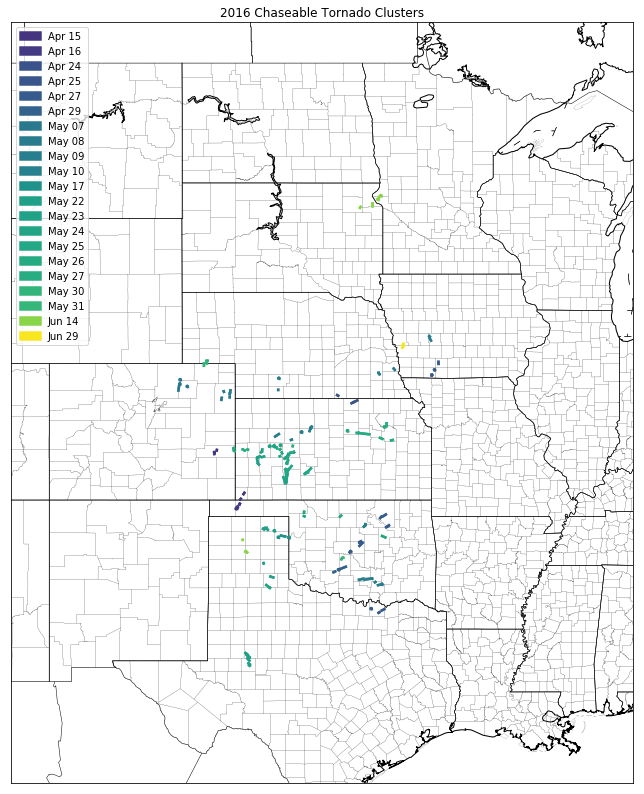

In [148]:
from matplotlib import patheffects
fig = plt.figure(figsize=(14, 14))
plot_cluster_groups(results.values(), buckets_for_year(2016), hwys=False, linewidth=2.5, 
                    patheffect=patheffects.withSimplePatchShadow((1, -1)))
plt.title('2016 Chaseable Tornado Clusters')